In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

import os
import json


Populating the interactive namespace from numpy and matplotlib


# IDEA:
## Older people are less likely than younger people to use bike during night time (21:00-5:00)

# NULL HYPOTHESIS:
## The ratio of older people (>=40) biking at night over all older people biking during a day is _the same_ or _higher_  than the ratio of younger people (< 40) biking at night to all the younger people biking during a day

# _$H_0$_ : $\frac{Y_{\mathrm{night}}}{Y_{\mathrm{24hour}}} <= \frac{O_{\mathrm{night}}}{O_{\mathrm{24hour}}}$
# _$H_1$_ : $\frac{Y_{\mathrm{night}}}{Y_{\mathrm{24hour}}} > \frac{O_{\mathrm{night}}}{O_{\mathrm{24hour}}}$

## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

## I am starting with a single month of data:  reading data from citibike csv file from Jan 2015

what I want is the date and time of the beginning of each trip. pandas has an easy method to read csv files, and an easy method to convert strinds to dates.

if i read a csv file with pandas the content is stored in a "DataFrame". You can think of it as a python dictionary in many ways,but it has many added capabilities: it is easy to convert variables within it, it knows how to plot itself, etc.

### download and move  data to PUIDATA
# NOTE: 
# 1. access to data from within the notebook _is required_
# 2. if data is downloaded it _must_ be stored in a directory pointed to by the environmental variable PUIDATA

In [2]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [16]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [17]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

In [18]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'gender'], axis=1, inplace=True)

In [19]:
df.head()

,birth year,date
0,1960.0,2015-01-01 00:01:00
1,1963.0,2015-01-01 00:02:00
2,1974.0,2015-01-01 00:04:00
3,1969.0,2015-01-01 00:04:00
4,1977.0,2015-01-01 00:05:00


### Lets separate males (_m) from females (_w) to test the hypotheses.
### In this csv file gender == 1 is male, gender == 2 is female

### Lets plot the number of trips per week day

In [20]:
df['age']=2017-df['birth year']

In [39]:
df.head()

,birth year,date,age
0,1960.0,2015-01-01 00:01:00,57.0
1,1963.0,2015-01-01 00:02:00,54.0
2,1974.0,2015-01-01 00:04:00,43.0
3,1969.0,2015-01-01 00:04:00,48.0
4,1977.0,2015-01-01 00:05:00,40.0


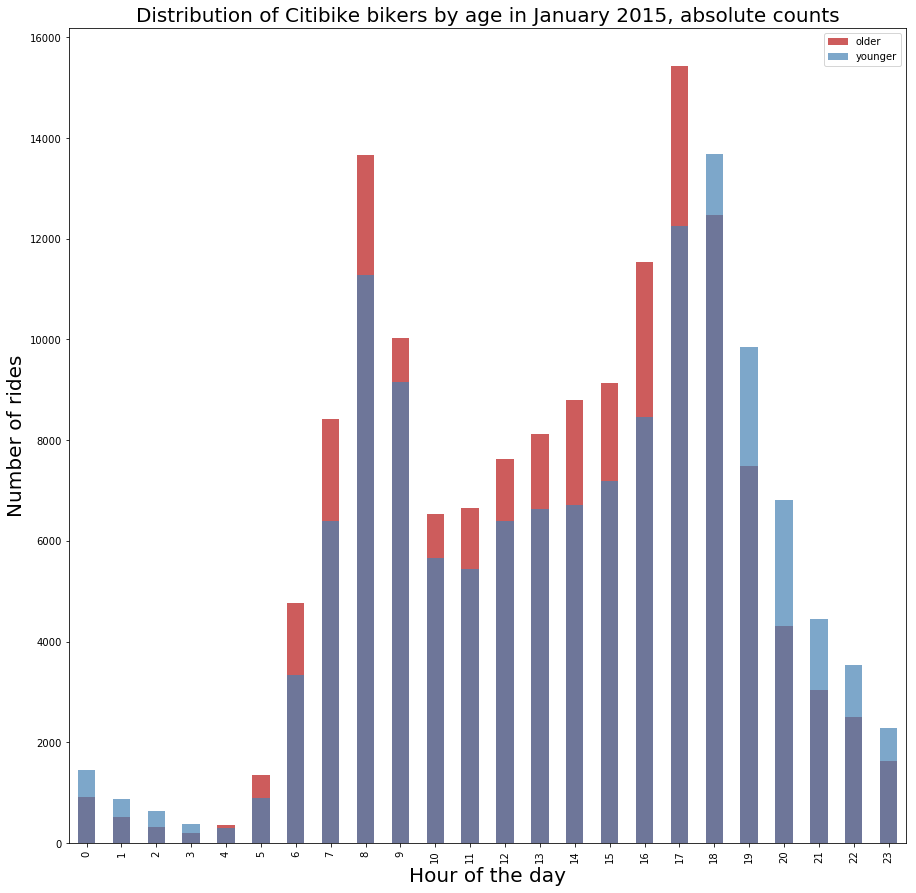

In [43]:
fig = pl.figure(figsize(15,15))
#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_o = 1
((df['date'][df['age'] >= 40].groupby([df['date'].dt.hour]).count()) / norm_o).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='older')

norm_y = 1
ax = ((df['date'][df['age'] < 40].groupby([df['date'].dt.hour]).count()) / norm_y).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.7,
                                                                                              label='younger')

#tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
pl.legend()
pl.title('Distribution of Citibike bikers by age in January 2015, absolute counts',fontsize=20)
pl.xlabel('Hour of the day',fontsize=20)
pl.ylabel('Number of rides',fontsize=20)

## Figure 1a: Distribution of Citibike bikers by age in January 2015, absolute counts

### Note: the counts have errors of course. what is the error on the count statistics? 
### for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

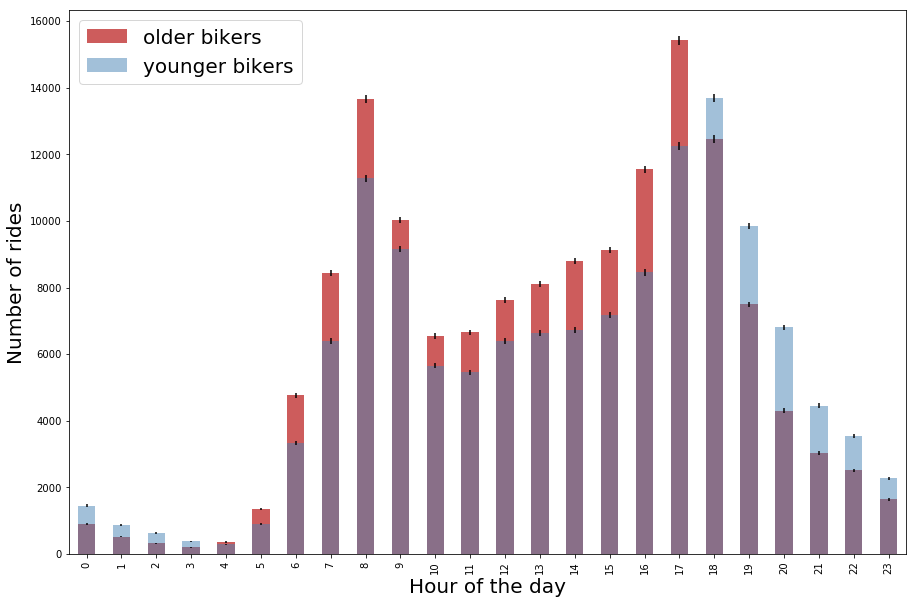

In [44]:
fig=pl.figure(figsize(15,10))

counts_o = df.date[df.age >= 40].groupby([df.date.dt.hour]).count()
norm_o = 1
error_o = np.sqrt(counts_o)
ax=((counts_o) / norm_o).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_o) / norm_o, (error_o) / norm_o)], label='older bikers')


counts_y = df.date[df.age < 40].groupby([df.date.dt.hour]).count()
norm_y = 1
error_y=np.sqrt(counts_y)
((counts_y) / norm_y).plot(kind="bar", alpha=0.5, yerr=[((error_y) / norm_y, (error_y) / norm_y)], 
                           color='SteelBlue', label='younger bikers')
#ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides",fontsize=20)
ax.set_xlabel ("Hour of the day",fontsize=20)
pl.legend(['older bikers','younger bikers'],fontsize=20)


## Figure 1b: Distribution of Citibike bikers by age in January 2015, absolute counts, with statistical errors

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's _normalize_ the distribution of man, and that of women, i.e. devide them by the total number of rides for that gender. 
(Notice that i have to normalize the errorbars too!)



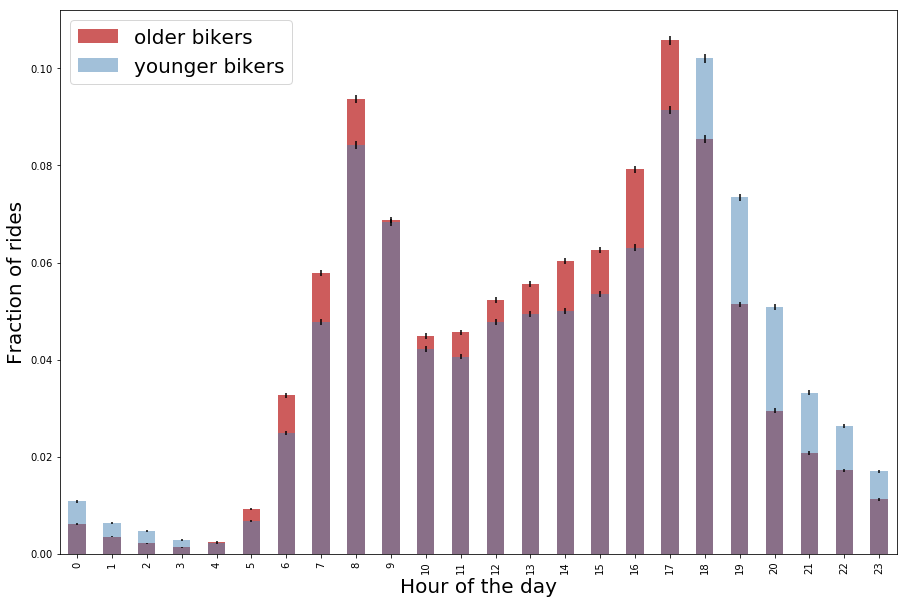

In [45]:
fig = pl.figure(figsize(15,10))

norm_o = counts_o.sum()
error_o = np.sqrt(counts_o)
((counts_o) / norm_o).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_o) / norm_o, (error_o) / norm_o)], 
                           label='older bikers')

norm_y = counts_y.sum()
ax = ((counts_y) / norm_y).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_y) / norm_y, (error_y) / norm_y)], 
                                color='SteelBlue', label='younger bikers')

#ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides",fontsize=20)
ax.set_xlabel ("Hour of the day",fontsize=20)

pl.legend(['older bikers','younger bikers'],fontsize=20)


## Figure 2: Distribution of Citibike bikers by age in January 2015, normalized

we can add up the week and weekend days, then this becomes a test of proportions, (like the one seen in the [employment notebook](https://github.com/fedhere/UInotebooks/blob/master/hypothesistesting/effectivenes%20of%20NYC%20Post-Prison%20Employment%20Programs.save.ipynb))

__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
# This is the portion of Assignment 2 that should be done by the week of September 26.  The rest will be due the following week.
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________


## Set up the test of proportions
### I need the fraction of women that bikes during the weekdays and the fraction that bikes during weekends, and the same for men

Men: week:0.820, weekend:0.180, weekend error:0.002, weekend error:0.001
Women: week:0.775, weekend:0.225, weekend error:0.004, weekend error:0.002


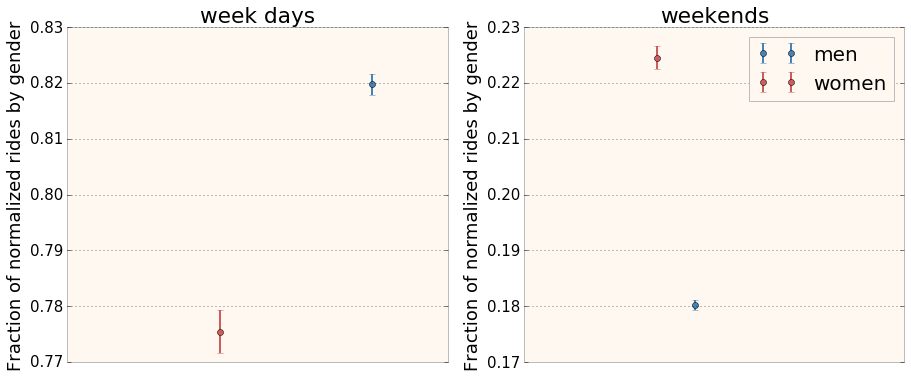

In [11]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_w = sum(counts_w[:-2]) * 1.0 / norm_w  #fraction of women riding on week days
weekend_w = sum(counts_w[-2:]) * 1.0 / norm_w  #fraction of women riding on weekends
eweek_w = np.sqrt(sum(error_w[:-2]**2)) / norm_w  #error on fraction number of women riding on week days
eweekend_w = np.sqrt(sum(error_w[-2:]**2)) / norm_w #error on fraction number of women riding on weekends

#same nomenclature as above
week_m = sum(counts_m[:-2]) * 1.0 / norm_m
weekend_m = sum(counts_m[-2:]) * 1.0 / norm_m
eweek_m = np.sqrt(sum(error_m[:-2]**2)) / norm_m
eweekend_m = np.sqrt(sum(error_m[-2:]**2)) / norm_m

print("Men: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_m, weekend_m, eweek_m, eweekend_m))
print("Women: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_w, weekend_w, eweek_w, eweekend_w))

ax1.errorbar([0.4], [week_m], yerr=[eweek_m], fmt='o', label='men')
ax1.errorbar([0.2], [week_w], yerr=[eweek_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_m], yerr=[eweekend_m], fmt='o', label='men')
ax2.errorbar([0.2], [weekend_w], yerr=[eweekend_w], fmt='o', label='women')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)

## Figure 3: Fraction of Citibike bikers per gender in January 2016 for week days (left) and weekends (right)

### Is the percentage of women that ride on weekends lower or equal to that of man?
## The statistics is: 
# $z = \frac{(p_0 - p_1)}{SE} $
# $p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$
# $SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$
## and in this notation 
# $p_0 = \frac{W_{\mathrm{weekend}}}{W_{\mathrm{week}}}$
### and 
# $p_1 = \frac{M_{\mathrm{weekend}}}{M_{\mathrm{week}}}$


In [12]:
P0mP1 = weekend_w - weekend_m
print ("difference between man and women on weekend: ", P0mP1)
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between man and women on weekend:  0.04432511723182847
We must check the significance before we reject the Null Hypothesis


### Is this difference statistically significant?

In [13]:
# defining the functions that calculate the statistics
# the lambda style definition is NOT APPROVED BY PEP8 and you should avoind it
# but I am putting it here since you may encounter it in your coding life.
# confront the equation in the markdown cell above with these function to understand as they work

p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

# calculations

sp_stdev_mw = se(p(weekend_w, weekend_m, norm_w, norm_m), norm_w, norm_m)
# print (sp_stdev_mw)
z = zscore(weekend_w, weekend_m, sp_stdev_mw)
print ("The z statistics is %.2f"%z) 

The z statistics is 23.34


## The largest number reported in  z stats tables is (thpically) 3, which gives  a p value
## $p <0.0002$, which is smaller then my chosen $\alpha=0.05$ - so yes, it is statistically significant (by a lot!)

# We reject the Null Hypothesis that man are more likely to commute than women $p< 0.05$


__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________

# Check the robustness of your answer with another citibike dataset (unless you used all of the data at once!)

## Lets see if our test holds in the summer, when people clothes may get less in the way to riding

### notice that it is not very pythonic to just copy and paste code as I am doing here! Everything that needs to be done more than once should be done in a function. Why? Because that way if I make any changes I do not run the risk to forget to make the change in one of the spots! (Also it helps readability)

In [14]:
datestring = '201506'
getCitiBikeCSV(datestring)

file in place, you can continue


In [15]:
df_06 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df_06['date'] = pd.to_datetime(df_06.starttime)
df_06.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984,1,2015-06-01 00:00:00
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997,1,2015-06-01 00:00:00
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993,1,2015-06-01 00:01:00
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981,1,2015-06-01 00:01:00
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0,2015-06-01 00:02:00


In [16]:
df_06.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)


In [17]:
df_06.head()

,gender,date
0,1,2015-06-01 00:00:00
1,1,2015-06-01 00:00:00
2,1,2015-06-01 00:01:00
3,1,2015-06-01 00:01:00
4,0,2015-06-01 00:02:00


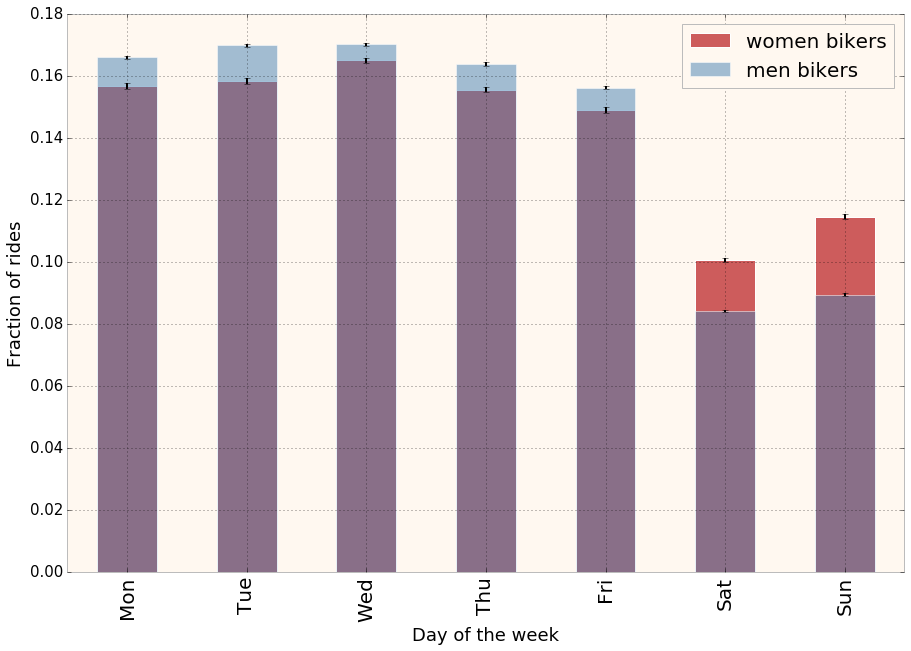

In [18]:
fig=pl.figure(figsize(15,10))

counts_w06 = df_06.date[df_06.gender == 2].groupby([df_06.date.dt.weekday]).count()
norm_w06 = counts_w06.sum()
error_w06 = np.sqrt(counts_w06)

((counts_w06) / norm_w06).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w06) / norm_w06, (error_w06) / norm_w06)], label='women bikers, June')

counts_m06 = df_06.date[df_06.gender==1].groupby([df_06.date.dt.weekday]).count()
norm_m06 = counts_m06.sum()
error_m06 = np.sqrt(counts_m06)
ax=((counts_m06) / norm_m06).plot(kind="bar", alpha=0.5, 
                                  yerr=[((error_m06) / norm_m06, (error_m06) / norm_m06)], 
                                  color="SteelBlue", label='men bikers, June')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")


pl.legend(['women bikers','men bikers'],fontsize=20)

## Figure 4: Distribution of Citibike bikers by gender in June 2016, normalized

Men: week:0.826, weekend:0.174, weekend error:0.001, weekend error:0.001
Women: week:0.785, weekend:0.215, weekend error:0.002, weekend error:0.001
The z statistics is 23.34


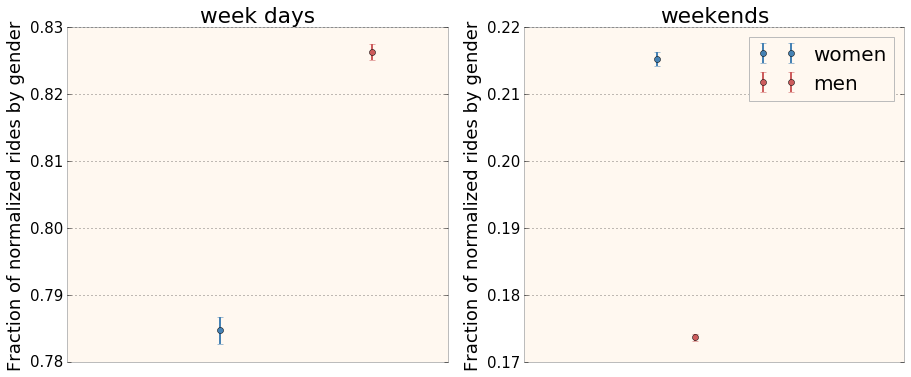

In [19]:
fig=pl.figure(figsize(15,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])

week_w06 = sum(counts_w06[:-2]) * 1.0 / norm_w06
weekend_w06 = sum(counts_w06[-2:])*1.0 / norm_w06
eweek_w06 = np.sqrt(sum(error_w06[:-2]**2)) / norm_w06
eweekend_w06 = np.sqrt(sum(error_w06[-2:]**2)) / norm_w06

week_m06 = sum(counts_m06[:-2]) * 1.0 / norm_m06
weekend_m06 = sum(counts_m06[-2:]) * 1.0 / norm_m06
eweek_m06 = np.sqrt(sum(error_m06[:-2]**2)) / norm_m06
eweekend_m06 = np.sqrt(sum(error_m06[-2:]**2)) / norm_m06

print("Men: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_m06, weekend_m06, eweek_m06, eweekend_m06))
print("Women: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_w06, weekend_w06, eweek_w06, eweekend_w06))

ax1.errorbar([0.2],[week_w06], yerr=[eweek_w06], fmt='o', label='women')
ax1.errorbar([0.4],[week_m06], yerr=[eweek_m06], fmt='o', label='men')
ax1.set_xlim(0,0.5)
ax2.errorbar([0.2],[weekend_w06], yerr=[eweekend_w06], fmt='o', label='women')
ax2.errorbar([0.4],[weekend_m06], yerr=[eweekend_m06], fmt='o', label='men')
ax1.set_xlim(0,0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by gender")
ax1.set_ylabel("Fraction of normalized rides by gender")

pl.xlim(-0.5,1.5)
pl.legend(fontsize=20)


sp_stdev_mw06 = se(p(weekend_w06, weekend_m06, norm_w06, norm_m06), norm_w06, norm_m06)
# print (sp_stdev_mw)
z06 = zscore(weekend_w06, weekend_m06, sp_stdev_mw06)
print ("The z statistics is %.2f"%z) 

## The z statstic is even larger in the Summer! Larger z means farther into the significance reagion
# We reject the Null Hypothesis that man are more likely to commute than women $p< 0.05$ in the summer aswell, 
# and my hypothesis is robust to seasonality


# BUT inreality ... there are many moreriders in the summer, 
# so the increase in statistical significance may not be due to a larger effect, but not to a larger effect.
# Let's check the _effect size_: 
# there are 2 formulae I find in the literature
# $r = \frac{z}{\sqrt{(n_0+n_1)}}$
# and
# $h =  2 (\arcsin \sqrt{p_0} -  \arcsin \sqrt{p_1} )$. https://en.wikipedia.org/wiki/Cohen%27s_h

In [20]:
r = lambda z, n0, n1 : z / np.sqrt(n0+n0)
h = lambda p0, p1: 2 * (np.arcsin(np.sqrt(p0)) - np.arcsin(np.sqrt(p1)))

In [21]:
r01 = r(z, norm_w, norm_m)
r06 = r(z06, norm_w06, norm_m06)
print (r01, r06)

0.0722973187379 0.0665254236989


In [22]:
h01 = h(weekend_w, weekend_m)
h06 = h(weekend_w06, weekend_m06)
print (h01, h06)

0.110468773483 0.105153243641


# In all these cases we have SMALL EFFECT SIZE, and in both cases slightly smaller for the summer data (although the statistiocal significance is slightly higher)